In [2]:
import torch
# output_collection = torch.load("/export/home/Experiments/20200819/s_test_speedup.repetition-3.pt")

In [18]:
import numpy as np
from tqdm import tqdm
for outputs in tqdm(output_collection):
    s_test_pytorch = outputs["s_test"]
    s_test = np.concatenate([X.numpy().flatten() for X in s_test_pytorch])
    outputs["s_test"] = s_test

100%|██████████| 280/280 [00:13<00:00, 21.25it/s]


In [26]:
outputs_by_index = [[] for _ in range(5)]
target_s_test = [None for _ in range(5)]
for outputs in tqdm(output_collection):
    outputs_by_index[outputs["test_index"]].append(outputs)
    if outputs["num_samples"] == 1300 and outputs["batch_size"] == 128:
        target_s_test[outputs["test_index"]] = outputs["s_test"]

100%|██████████| 280/280 [00:00<00:00, 512169.70it/s]


0.00036482935

In [31]:
for outputs in tqdm(output_collection):
    diff_norm = np.linalg.norm(outputs["s_test"] - target_s_test[outputs["test_index"]])
    outputs["diff_norm"] = diff_norm

100%|██████████| 280/280 [00:06<00:00, 45.59it/s]


In [34]:
for outputs in tqdm(output_collection):
    outputs.pop("s_test")

100%|██████████| 280/280 [00:00<00:00, 3054.93it/s]


In [32]:
import pandas as pd

In [48]:
df = pd.DataFrame(output_collection)

In [49]:
df

,test_index,num_samples,batch_size,repetition,time_elapsed,diff_norm
0,0,700,1,0,25.385064,3.292313e-04
1,0,700,2,0,24.897423,3.108057e-04
2,0,700,4,0,25.404797,2.949672e-04
3,0,700,8,0,34.759400,2.925861e-04
4,0,700,16,0,64.098297,2.959292e-04
...,...,...,...,...,...,...
275,4,1300,8,0,64.450214,1.063085e-07
276,4,1300,16,0,118.596105,9.199741e-08
277,4,1300,32,0,214.711344,5.772556e-08
278,4,1300,64,0,420.902801,4.807385e-08


In [51]:
import matplotlib.pyplot as plt

In [112]:
from collections import defaultdict
dfmeans = df.groupby(["num_samples", "batch_size"]).mean()[["time_elapsed", "diff_norm"]]
dfstds = df.groupby(["num_samples", "batch_size"]).std()[["time_elapsed", "diff_norm"]]
time_data = defaultdict(dict)
diff_data = defaultdict(dict)
for row_m, row_s in zip(dfmeans.iterrows(), dfstds.iterrows()):
    if row_m[0] != row_s[0]:
        raise ValueError
    n, b = row_m[0]
    time_data[n][b] = (row_m[1].time_elapsed, row_s[1].time_elapsed)
    diff_data[n][b] = (row_m[1].diff_norm, row_s[1].diff_norm)
    
    
display(dfmeans.transpose())
display(dfstds.transpose())

num_samples        700                                               \
batch_size          1          2          4          8          16    
time_elapsed  25.382221  25.171853  25.556941  34.794770  64.017047   
diff_norm      0.000285   0.000284   0.000269   0.000268   0.000271   

num_samples                                            800              ...  \
batch_size           32          64          128        1          2    ...   
time_elapsed  115.844795  227.016209  435.986514  28.704256  28.342973  ...   
diff_norm       0.000268    0.000268    0.000268   0.000213   0.000210  ...   

num_samples         1200                   1300                        \
batch_size           64          128        1          2          4     
time_elapsed  388.594356  746.368400  46.914661  46.477748  47.330031   
diff_norm       0.000028    0.000028   0.000050   0.000037   0.000028   

num_samples                                                              
batch_size          8           16          32          64          128  
time_elapsed  64.503285  118.624598  214.729251  420.984355  808.515953  
diff_norm      0.000019    0.000013    0.000010    0.000008    0.000000  

[2 rows x 56 columns]

num_samples       700                                                     \
batch_size         1         2         4         8         16        32    
time_elapsed  0.494334  0.554097  0.751375  0.045805  0.054415  0.078518   
diff_norm     0.000274  0.000279  0.000259  0.000260  0.000264  0.000258   

num_samples                           800             ...      1200            \
batch_size         64        128       1         2    ...       64        128   
time_elapsed  0.047066  0.199127  0.431178  0.399971  ...  0.040147  0.224317   
diff_norm     0.000258  0.000258  0.000204  0.000206  ...  0.000027  0.000027   

num_samples       1300                                                    \
batch_size         1         2         4         8         16        32    
time_elapsed  0.685342  0.660522  0.328345  0.064294  0.085348  0.095945   
diff_norm     0.000052  0.000040  0.000030  0.000020  0.000014  0.000010   

num_samples                       
batch_size         64        128  
time_elapsed  0.178359  0.311947  
diff_norm     0.000008  0.000000  

[2 rows x 56 columns]

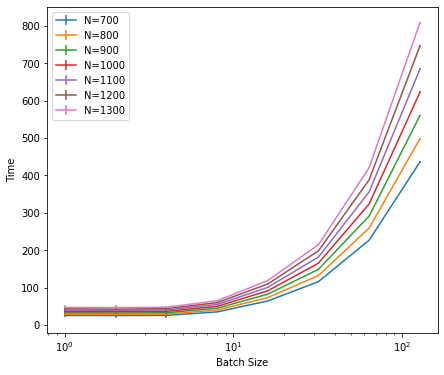

In [138]:
plt.figure(figsize=(7,6))
for k in sorted(time_data.keys()):
    Ys = []
    Xs = []
    Ys_e = []
    for _k in sorted(time_data[k].keys()):
        Ys.append(time_data[k][_k][0])
        Ys_e.append(time_data[k][_k][1] * 10)
        Xs.append(_k)
    plt.errorbar(Xs, Ys, yerr=Ys_e, label=f"N={k}")
plt.legend()
plt.xlabel("Batch Size")
plt.ylabel("Time")
plt.xscale("log")
plt.savefig("./20200819-stest-speedup-time.pdf")

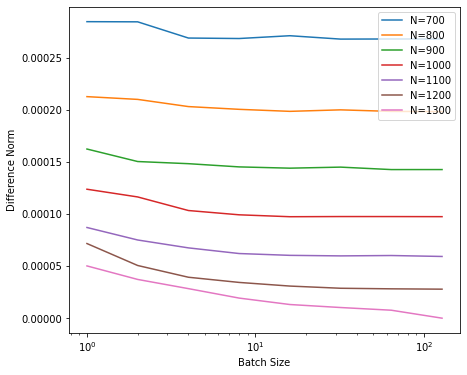

In [139]:
plt.figure(figsize=(7,6))
for k in sorted(diff_data.keys()):
    Ys = []
    Xs = []
    Ys_e = []
    for _k in sorted(diff_data[k].keys()):
        Ys.append(diff_data[k][_k][0])
        Ys_e.append(diff_data[k][_k][1])
        Xs.append(_k)
    # plt.errorbar(Xs, Ys, yerr=Ys_e, label=f"N={k}")
    plt.errorbar(Xs, Ys, label=f"N={k}")
plt.legend()
plt.xlabel("Batch Size")
plt.ylabel("Difference Norm")
plt.xscale("log")
plt.savefig("./20200819-stest-diffnorm-time.pdf")